# Major Leagues

Basketball is a data scientist's dream. Lots of games lead to a lot of data, and almost all of that data is numerical. Points, timings, ratings, forecasts, all can be analyzed and all can be predicted. To a point. In this project, I am going to use different **regression** models with different features in order to predict the scores to games.

## Retrieving the Data
This data comes from the [FiveThirtyEight data on NBA scores](https://github.com/fivethirtyeight/data/tree/master/nba-elo). Note: this is not the _nba-carmelo_ link that was on the project desription, but that link is broken, so I will be using the _nba-elo_ dataset. This is similar to the other datasets listed in the project description.

We will begin by loading the dataset into a dataframe:

In [1]:
from os import path
import numpy as np
import pandas as pd

nba_df = pd.read_csv("data/raw/nbaallelo.csv")
nba_df.head()

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


Let's run through some quick information about this dataset:

In [2]:
nba_df.shape

(126314, 23)

In [3]:
nba_df.keys()

Index(['gameorder', 'game_id', 'lg_id', '_iscopy', 'year_id', 'date_game',
       'seasongame', 'is_playoffs', 'team_id', 'fran_id', 'pts', 'elo_i',
       'elo_n', 'win_equiv', 'opp_id', 'opp_fran', 'opp_pts', 'opp_elo_i',
       'opp_elo_n', 'game_location', 'game_result', 'forecast', 'notes'],
      dtype='object')

In order to effectively use this dataset, let's analyze the columns:

|Key           |Description|
|:-------------|:----------|
|gameorder     | Play order of game in NBA history|
|game_id       | Unique ID for each game|
|lg_id         | Which league the game was played in|
|\_iscopy      | Each row of data is tied to a single team for a single game, so \_iscopy flags if this game_id has already occured for the opposing team in the same matchup|
|year_id       | Season id, named based on year in which the season ended|
|date_game     | Game date|
|seasongame    | 1 if game is a season game|
|is_playoffs   | Flag for playoff games|
|team_id       | Three letter code for team name, from Basketball Reference|
|fran_id       | Franchise id. Multiple team_ids can fall under the same fran_id due to name changes or moves. Interactive is grouped by fran_id.|
|pts           | Points scored by team|
|elo_i         | Team elo entering the game|
|elo_n         | Team elo following the game|
|win_equiv     | Equivalent number of wins in a 82-game season for a team of elo_n quality|
|opp_id        | Team id of opponent|
|opp_fran      | Franchise id of opponent|
|opp_pts       | Points scored by opponent|
|opp_elo_i     | Opponent elo entering the game|
|opp_elo_n     | Opponent elo following the game|
|game_location | Home (H), away (A), or neutral (N)|
|game_result   | Win or loss for team in the team_id column|
|forecast      | Elo-based chances of winning for the team in the team_id column, based on elo ratings and game location|
|notes         | Additional information|

## Cleaning Up the Data
This data is fairly clean, but we could do one thing to make it a little more manageable. At the moment, we have **126314** rows of data, but half of those are duplicates with the opponent team as the main team. We can get rid of these rows without a whole lot of issues. The only thing we would be losing is the opponent's `win_equiv` score and `forecast`, so let's add those before we get rid of them.

We can also get rid of a few columns that aren't going to be useful in our analysis. These include `seasongame`, `is_playoffs`, `fran_id`, `opp_fran`, `game_location`, and `notes`. `seasongame`, `is_playoffs`, and `game_location` don't have anything to do with specific game data, the franchise IDs are redundant as we already have the team IDs, and `notes` only has information on where the game is being played, similar to `game_location`:

In [4]:
nba_df["notes"].value_counts()

at New York NY         440
at Philadelphia PA     256
at Norfolk VA          240
at Boston MA           232
at Greensboro NC       218
                      ... 
at Springfield, MA       2
at Bakersfield CA        2
at Muscatine IA          2
at Oklahoma City OK      2
at Connellsville PA      2
Name: notes, Length: 231, dtype: int64

Now we can get rid of these things and focus on the points and elo scores. We will save this in a new processed csv file as it can take a while:

In [5]:
# Check if we have already cleaned the data:
if not path.exists("data/processed/nba_data_cleaned.csv"):

    def get_opp_win_equiv_forecast(row):
        if row["_iscopy"] == 1: # We will be deleting the row anyways, just ignore it
            return [0, 0]
        game_info = nba_df.loc[nba_df["game_id"] == row["game_id"], ["team_id", "win_equiv", "forecast"]]
        opp_win_equiv = game_info.loc[game_info["team_id"] != row["team_id"], ["win_equiv"]].values[0][0]
        opp_forecast = game_info.loc[game_info["team_id"] != row["team_id"], ["forecast"]].values[0][0]
        return [opp_win_equiv, opp_forecast]

    # Add the opponent's win_equiv score
    nba_df[["opp_win_equiv", "opp_forecast"]] = pd.DataFrame(list(nba_df.apply(get_opp_win_equiv_forecast, axis=1)))

    indices_to_drop = nba_df[nba_df["_iscopy"] == 1].index
    nba_df.drop(indices_to_drop, inplace=True) # Get rid of duplicates
    nba_df.drop(columns=["_iscopy"], inplace=True) # We have no use for this column anymore

    # Get rid of other columns
    nba_df.drop(columns=["seasongame", "is_playoffs", "fran_id", "opp_fran", "game_location", "notes"], inplace=True)

    # Save the cleaned data to a csv file
    nba_df.to_csv("data/processed/nba_data_cleaned.csv")

# If we have already cleaned the data, retrieve it from the file
else:
    nba_df = pd.read_csv("data/processed/nba_data_cleaned.csv")
    nba_df.drop(nba_df.columns[0], axis=1, inplace=True) # Get rid of index column

nba_df.head()

,gameorder,game_id,lg_id,year_id,date_game,team_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_pts,opp_elo_i,opp_elo_n,game_result,forecast,opp_win_equiv,opp_forecast
0,1,194611010TRH,NBA,1947,11/1/1946,TRH,66,1300.0,1293.2767,40.294830,NYK,68,1300.0000,1306.7233,L,0.640065,41.705170,0.359935
1,2,194611020CHS,NBA,1947,11/2/1946,CHS,63,1300.0,1309.6521,42.012257,NYK,47,1306.7233,1297.0712,W,0.631101,40.692783,0.368899
2,3,194611020DTF,NBA,1947,11/2/1946,DTF,33,1300.0,1279.6189,38.864048,WSC,50,1300.0000,1320.3811,L,0.640065,43.135952,0.359935
3,4,194611020PRO,NBA,1947,11/2/1946,PRO,59,1300.0,1305.1542,41.540619,BOS,53,1300.0000,1294.8458,W,0.640065,40.459381,0.359935
4,5,194611020STB,NBA,1947,11/2/1946,STB,56,1300.0,1304.6908,41.492020,PIT,51,1300.0000,1295.3092,W,0.640065,40.507980,0.359935


Let's also change the date format so that we are using date objects:

In [6]:
nba_df["date_game"] = pd.to_datetime(nba_df["date_game"], format="%m/%d/%Y")
nba_df.head()

,gameorder,game_id,lg_id,year_id,date_game,team_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_pts,opp_elo_i,opp_elo_n,game_result,forecast,opp_win_equiv,opp_forecast
0,1,194611010TRH,NBA,1947,1946-11-01,TRH,66,1300.0,1293.2767,40.294830,NYK,68,1300.0000,1306.7233,L,0.640065,41.705170,0.359935
1,2,194611020CHS,NBA,1947,1946-11-02,CHS,63,1300.0,1309.6521,42.012257,NYK,47,1306.7233,1297.0712,W,0.631101,40.692783,0.368899
2,3,194611020DTF,NBA,1947,1946-11-02,DTF,33,1300.0,1279.6189,38.864048,WSC,50,1300.0000,1320.3811,L,0.640065,43.135952,0.359935
3,4,194611020PRO,NBA,1947,1946-11-02,PRO,59,1300.0,1305.1542,41.540619,BOS,53,1300.0000,1294.8458,W,0.640065,40.459381,0.359935
4,5,194611020STB,NBA,1947,1946-11-02,STB,56,1300.0,1304.6908,41.492020,PIT,51,1300.0000,1295.3092,W,0.640065,40.507980,0.359935


Let's also check for any null values:

In [7]:
nba_df[nba_df.isna().any(axis=1)].shape[0]

0

Awesome, no null values! Let's move on then.

## Feature Engineering


One feature that could help gain more value from feature engineering would be the win-ratio for the season, which can easily be found per team:

In [8]:
win_ratios = nba_df.groupby(["team_id", "year_id"])["game_result"].sum()\
    .apply(lambda s: s.count("W") / len(s)).reset_index().rename(columns={"game_result": "win_ratio"})
nba_df = pd.merge(nba_df , win_ratios, on=["team_id", "year_id"])

nba_df.loc[nba_df["team_id"] == "BRK"]["win_ratio"].unique()

array([0.62222222, 0.67391304, 0.47727273])

With this, we will be able to predict the outcome of a match much better

Let's also change the `game_result` column to output a `1` or a `0`, as booleans are easier to use than characters. Let's also change the column name to make it a little more accurate with the converted data:

In [9]:
def game_result_converter(res):
    if res == "W":
        return True
    return False
nba_df["game_result"] = nba_df["game_result"].apply(game_result_converter)
nba_df = nba_df.rename(columns={"game_result": "game_won"})
nba_df.head()

,gameorder,game_id,lg_id,year_id,date_game,team_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_pts,opp_elo_i,opp_elo_n,game_won,forecast,opp_win_equiv,opp_forecast,win_ratio
0,1,194611010TRH,NBA,1947,1946-11-01,TRH,66,1300.0000,1293.2767,40.294830,NYK,68,1300.0000,1306.7233,False,0.640065,41.705170,0.359935,0.5
1,13,194611080TRH,NBA,1947,1946-11-08,TRH,73,1286.1534,1289.1691,39.864174,DTF,71,1271.4624,1268.4468,True,0.659309,37.697380,0.340691,0.5
2,25,194611150TRH,NBA,1947,1946-11-15,TRH,85,1283.6519,1294.7554,40.449894,PRO,68,1313.4436,1302.3401,True,0.599685,41.245461,0.400315,0.5
3,35,194611190TRH,NBA,1947,1946-11-19,TRH,72,1284.4910,1278.2225,38.718002,CLR,74,1307.6647,1313.9331,False,0.608795,42.460903,0.391205,0.5
4,42,194611220TRH,NBA,1947,1946-11-22,TRH,83,1278.2225,1280.6818,38.975250,BOS,82,1257.9297,1255.4705,True,0.666514,36.349152,0.333486,0.5


## Analysis

Let's do some analysis! Let's start by taking a look at the data:

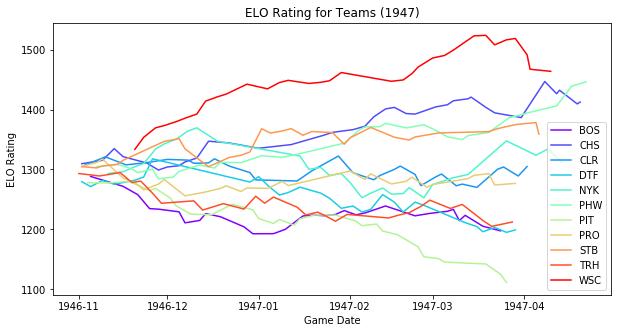

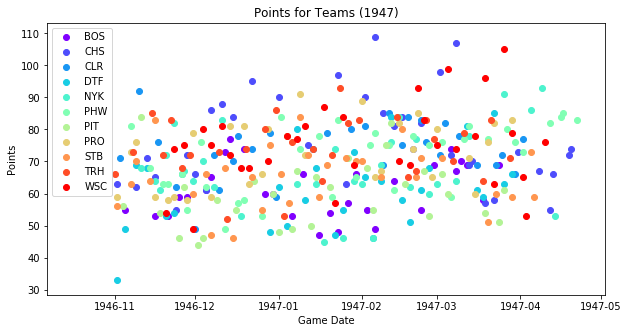

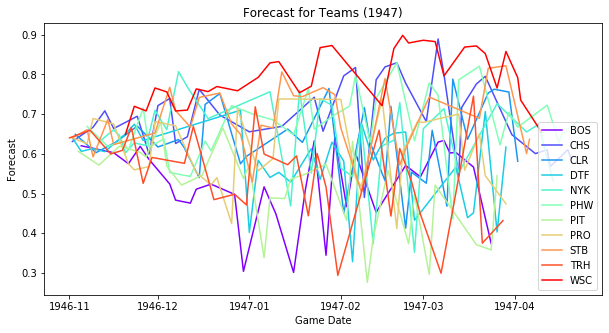

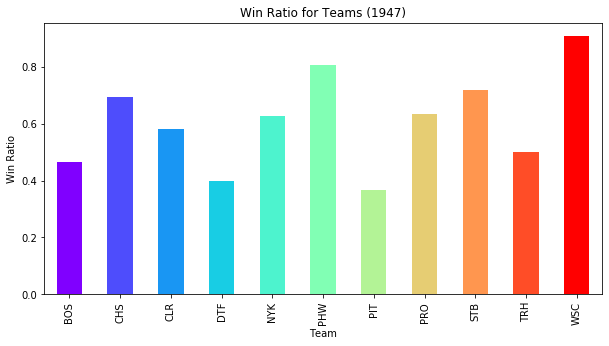

In [11]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Define what values we will be graphing
keys = [("elo_n", "ELO Rating"), ("pts", "Points"), ("forecast", "Forecast")]

year = 1947 # First date
year_data = nba_df.loc[nba_df["year_id"] == year]
colors = cm.rainbow(np.linspace(0, 1, year_data["team_id"].unique().size))

# For all key-value pairs
for (k, v) in keys:
    plt.figure(figsize=(10, 5))

    data = year_data.groupby(["team_id"])\
        .apply(lambda row: np.array(list(zip(row["date_game"], row[k], row["team_id"]))))
    data = np.array(list(data))

    # Display all teams in a graph
    i = 0
    for d in data:
        if v == "Points":
            plt.scatter(d[:,0], d[:,1], color=colors[i], label=d[:,2][0])
        else:
            plt.plot(d[:,0], d[:,1], color=colors[i], label=d[:,2][0])
        i += 1
    plt.title("%s for Teams (%s)" % (v, year))
    plt.xlabel("Game Date")
    plt.ylabel(v)
    plt.legend()

# Show win ratio in a bar graph
data = year_data.groupby(["team_id"]).head(1)[["team_id", "win_ratio"]].sort_values(by="team_id")

data.plot.bar(x="team_id", y="win_ratio", legend=False, figsize=(10, 5), color=colors)
plt.title("Win Ratio for Teams (%s)" % year)
plt.xlabel("Team")
plt.ylabel("Win Ratio")
plt.show()

Our end goal is to compute the scores for specific teams, and according to the graphs, it looks like that may be a challenge. Out of all of the things to predict, `Points` seem to be the most volatile, while things like `ELO Rating` and `Forecast` seem to follow a very predictable path. We may not be able to use these things to accurately predict the points of a game. Let's focus on more game-specific data:

In order to make our results as accurate as possible, we should only choose one team to focus on. This team should have the most data points, as that will be best to train our models on.

In [12]:
nba_df["team_id"].value_counts()

BOS    3100
NYK    2855
LAL    2559
DET    2532
PHI    2215
       ... 
CLR      31
PIT      30
TRH      30
DTF      30
SDS       3
Name: team_id, Length: 104, dtype: int64

Boston it is! Let's continue focusing on more game-specific data with Boston's team:

### Boston Analysis

In [13]:
bos_df = nba_df.loc[nba_df["team_id"] == "BOS"]
bos_df.head()

,gameorder,game_id,lg_id,year_id,date_game,team_id,pts,elo_i,elo_n,win_equiv,opp_id,opp_pts,opp_elo_i,opp_elo_n,game_won,forecast,opp_win_equiv,opp_forecast,win_ratio
219,8,194611050BOS,NBA,1947,1946-11-05,BOS,55,1294.8458,1288.4139,39.785030,CHS,57,1309.6521,1316.0840,False,0.620204,42.686188,0.379796,0.466667
220,26,194611160BOS,NBA,1947,1946-11-16,BOS,53,1267.1501,1271.9004,38.057545,TRH,49,1294.7554,1290.0051,True,0.602702,39.951809,0.397298,0.466667
221,39,194611210BOS,NBA,1947,1946-11-21,BOS,53,1271.9004,1257.9297,36.603973,STB,65,1319.3402,1333.3109,False,0.575068,44.485733,0.424932,0.466667
222,49,194611250BOS,NBA,1947,1946-11-25,BOS,59,1250.1028,1234.6626,34.209530,PRO,71,1265.9526,1281.3928,False,0.618788,39.049664,0.381212,0.466667
223,57,194611280BOS,NBA,1947,1946-11-28,BOS,59,1228.7905,1233.7903,34.120571,PIT,55,1268.6437,1263.6439,True,0.585704,37.197369,0.414296,0.466667


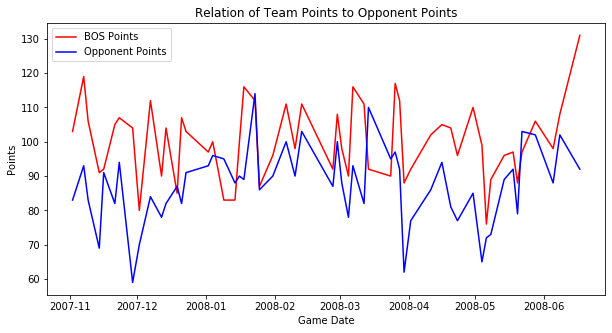

In [14]:
plt.figure(figsize=(10, 5))

year = bos_df["year_id"].value_counts().index[0] # Find year with most games
year_data = bos_df.query("year_id == {}".format(year))

points_data = year_data.apply(lambda row: list((row["date_game"], row["pts"])), axis=1)
points_data = np.array(list(points_data))

plt.title("Relation of Team Points to Opponent Points")
plt.xlabel("Game Date")
plt.ylabel("Points")
plt.plot(points_data[:,0], points_data[:,1], color="red", label="BOS Points")

opp_points_data = year_data.apply(lambda row: row["opp_pts"], axis=1)
opp_points_data = np.array(list(opp_points_data))

plt.plot(points_data[:,0], opp_points_data, color="blue", label="Opponent Points")

plt.legend()
plt.show()

Aha, now we're getting somewhere! It looks like the opponent points roughly follow a similar trajectory as the team's points as the season goes on. With this in mind, let's do some regression!

### Using Opponent Points to Estimate Team's Points

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

labels = bos_df["pts"]
test_size = 0.20 # Test size is 20% of all rows
# Splitting the data between 80% train and 20% test
features = bos_df[["date_game", "opp_pts"]]
training_f, testing_f, training_l, testing_l = train_test_split(features, labels, test_size=test_size)

In [16]:
# Decision Tree
dt_reg = DecisionTreeRegressor()
dt_reg.fit(training_f[["opp_pts"]], training_l)
dt_reg_prediction = dt_reg.predict(testing_f[["opp_pts"]])
dt_reg_score = r2_score(testing_l, dt_reg_prediction)
print("Decision Tree r2 Score: {}".format(dt_reg_score))

Decision Tree r2 Score: 0.4602659405808124


In [17]:
# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(training_f[["opp_pts"]], training_l)
rf_reg_prediction = rf_reg.predict(testing_f[["opp_pts"]])
rf_reg_score = r2_score(testing_l, rf_reg_prediction)
print("Random Forest r2 Score: {}".format(rf_reg_score))

Random Forest r2 Score: 0.46226644857839894


In [18]:
# Gradient Boosting
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts"]])
gb_reg_score = r2_score(testing_l, gb_reg_prediction)
print("Gradient Boosting r2 Score: {}".format(gb_reg_score))

Gradient Boosting r2 Score: 0.4658816716584151


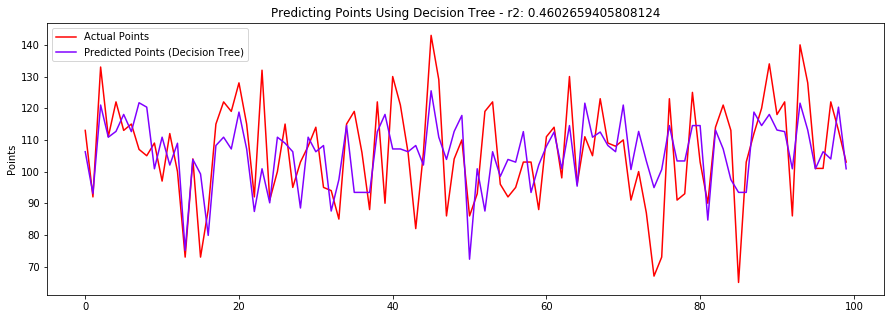

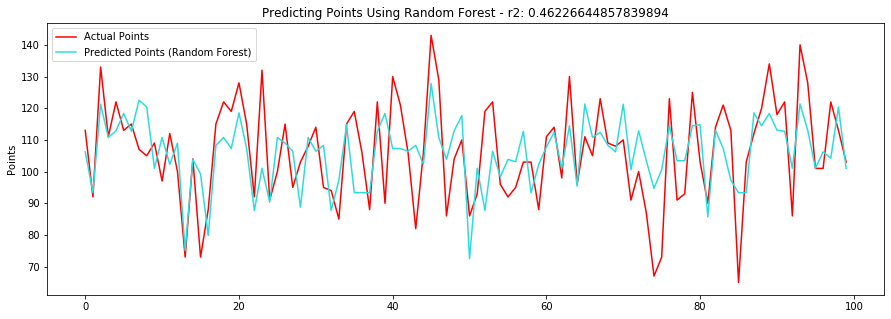

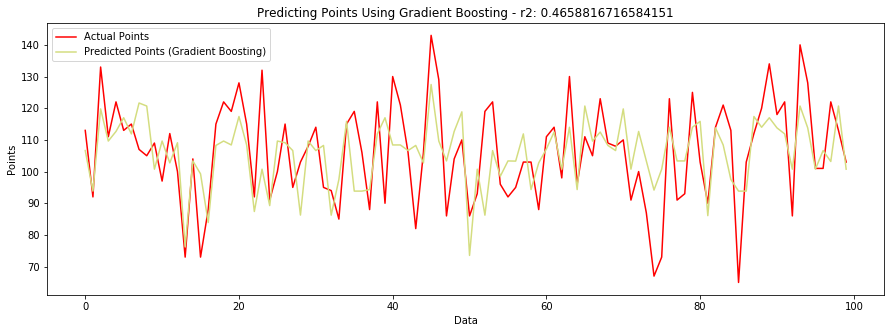

In [19]:
X = range(testing_f.shape[0])

predictions = [("Decision Tree", dt_reg_prediction, dt_reg_score), ("Random Forest", rf_reg_prediction, rf_reg_score),
               ("Gradient Boosting", gb_reg_prediction, gb_reg_score)]
colors = cm.rainbow(np.linspace(0, 1, len(predictions) + 1))

for i, (label, pred, pred_score) in enumerate(predictions):
    plt.figure(figsize=(15, 5))
    plt.title("Predicting Points Using {} - r2: {}".format(label, pred_score))
    plt.ylabel("Points")
    plt.plot(X[:100], testing_l[:100], color=colors[len(predictions)], label="Actual Points")
    plt.plot(X[:100], pred[:100], color=colors[i], label="Predicted Points ({})".format(label))

    plt.legend()
plt.xlabel("Data")
plt.show()

With an average prediction score of around **0.45** this isn't an awful prediction, but it's still not great. This is to be expected, considering how random the points can actually be. Let's try and use some other features to see if we can increase our score! For the following regressions, I will be using `Gradient Boosting`, as it seems to give the best results (I will elaborate more on this in the conclusion).

### Using Opponent Points in Collaboration with Other Features to Improve Predictions
To improve predictions, let's try a variety of factors, including those we looked at earlier in the notebook, as well as the features we created in feature engineering:

In [20]:
features = bos_df[["date_game", "opp_pts", "elo_n", "forecast", "game_won", "win_ratio"]]
training_f, testing_f, training_l, testing_l = train_test_split(features, labels, test_size=test_size)

In [21]:
# Opponent Points w/ ELO Rating
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts", "elo_n"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts", "elo_n"]])
gb_reg_score = r2_score(testing_l, gb_reg_prediction)
print("ELO Rating r2 Score: {}".format(gb_reg_score))

ELO Rating r2 Score: 0.5291214983704817


In [22]:
# Opponent Points w/ Forecast
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts", "forecast"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts", "forecast"]])
gb_reg_score = r2_score(testing_l, gb_reg_prediction)
print("Forecast r2 Score: {}".format(gb_reg_score))

Forecast r2 Score: 0.5158941486733677


In [23]:
# Opponent Points w/ Win Ratio
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts", "win_ratio"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts", "win_ratio"]])
gb_reg_score = r2_score(testing_l, gb_reg_prediction)
print("Win Ratio r2 Score: {}".format(gb_reg_score))

Win Ratio r2 Score: 0.5348865409512695


In [24]:
# Opponent Points w/ Game Won
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts", "game_won"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts", "game_won"]])
gb_reg_score = r2_score(testing_l, gb_reg_prediction)
print("Game Won r2 Score: {}".format(gb_reg_score))

Game Won r2 Score: 0.7560682401177081


_WOAH_. Well that worked well! It looks like our best results came from if the regressor knew if the team won the game or not. This would make sense, as the regressor could more accurately know that if the team won the game, then the predicted points must be greater than the opponents points (at least, that's how I interpret the boost in performance). Also notable is that `Forecast`, `ELO Rating`, and `Win Ratio` are not very good indicators of the amount of `Points`. This was to be expected, as the points distribution is much more random than any of those features.

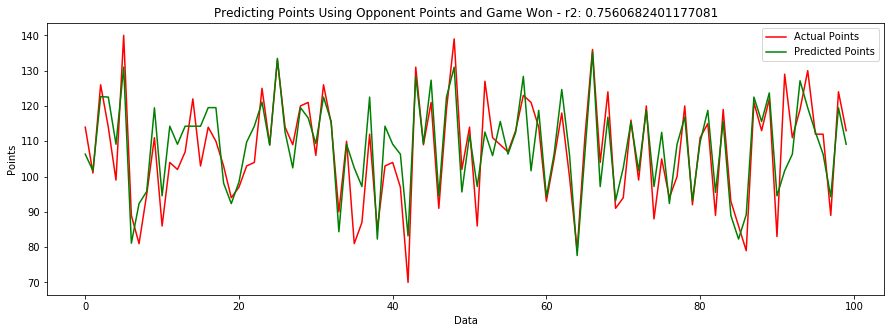

In [25]:
plt.figure(figsize=(15, 5))
plt.title("Predicting Points Using Opponent Points and Game Won - r2: {}".format(gb_reg_score))
plt.xlabel("Data")
plt.ylabel("Points")
plt.plot(X[:100], testing_l[:100], color="red", label="Actual Points")
plt.plot(X[:100], gb_reg_prediction[:100], color="green", label="Predicted Points")
plt.legend()
plt.show()

As a final test, I wonder if combining any more features could get us any better results:

In [26]:
# Opponent Points w/ Game Won and Win Ratio
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts", "game_won", "win_ratio"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts", "game_won", "win_ratio"]])
print("Game Won & Win Ratio r2 Score: {}".format(r2_score(testing_l, gb_reg_prediction)))

Game Won & Win Ratio r2 Score: 0.7679398117618716


In [27]:
# Opponent Points w/ everything
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(training_f[["opp_pts", "elo_n", "forecast", "game_won", "win_ratio"]], training_l)
gb_reg_prediction = gb_reg.predict(testing_f[["opp_pts", "elo_n", "forecast", "game_won", "win_ratio"]])
print("Everything r2 Score: {}".format(r2_score(testing_l, gb_reg_prediction)))

Everything r2 Score: 0.7686053459970208


Huh, I suppose it does get better, but only by a couple points - not quite enough to get excited about. We are also roaming into over-fitting territory here.

## Conclusion
Overall, we ended up with an r2 score of almost **0.8**, which is honestly pretty good! Still not great, but very close to the actual game score! **Gradient Boosting** ended up being the most accurate, with **Decision Tree** and **Random Forest** being tied for accuracy. This makes sense because Gradient Boosting combines many weak models into one strong model, which is an advantage that Decision Trees don't have. We also got the best results by combining `Opponent Points` with `Game Won`. This combination surprised me. I thought that `Opponent Points` would be fairly accurate, as they followed a similar trajectory to the desired team points, but the addition of `Game Won` spiked the accuracy in a way I was not expecting. The only way I can think that this helps is if the learner figured out that if game won is true, than the predicted score must be greater than the opponent score.

Overall, this gave me a lot of experience with regression and handling a lot of data!